In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

print('Imports Complete')

Solving environment: done

# All requested packages already installed.

Imports Complete


In [2]:
#Download NYC Data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [3]:
#Create Dataframe

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
#Add Latitude and Longitude for only Neighborhoods in 
address = 'Brooklyn, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [5]:
#Create Brooklyn Dataframe
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [6]:
#Add Foursquare Info
CLIENT_ID = 'VZZUNJ1QDG0DO1GFXFHUZEQ5KUIZWMFDEW51PIUIZFFQLVQX' # your Foursquare ID
CLIENT_SECRET = 'QJINVRF30450RMHARF2QR25GFGNYOI45IMAWQ15AVOWJNGHB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VZZUNJ1QDG0DO1GFXFHUZEQ5KUIZWMFDEW51PIUIZFFQLVQX
CLIENT_SECRET:QJINVRF30450RMHARF2QR25GFGNYOI45IMAWQ15AVOWJNGHB


In [7]:
#Retrieve Top Venues for each Neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
#Create New Dataframe for Brooklyn Venues

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )
brooklyn_venues.head()

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


In [9]:
brooklyn_pizza = brooklyn_venues.loc[brooklyn_venues['Venue Category'] == 'Pizza Place']
brooklyn_pizza.shape
    

(123, 7)

In [10]:
map_brooklyn_pizza = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(brooklyn_pizza['Venue Latitude'], brooklyn_pizza['Venue Longitude'], brooklyn_pizza['Venue']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn_pizza)  

map_brooklyn_pizza

In [11]:
#Analyze with one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy

In [12]:
#Group rows by neighborhoods and take mean of frequency of occurence of each category
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy

In [13]:
#Calculate top 10 venues for each neighborhood
num_top_venues = 10

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Bath Beach----
                  venue  freq
0    Chinese Restaurant  0.06
1  Fast Food Restaurant  0.04
2              Pharmacy  0.04
3    Italian Restaurant  0.04
4       Bubble Tea Shop  0.04
5          Dessert Shop  0.04
6  Cantonese Restaurant  0.04
7           Pizza Place  0.04
8            Donut Shop  0.04
9           Gas Station  0.04


----Bay Ridge----
                 venue  freq
0                  Spa  0.08
1   Italian Restaurant  0.06
2          Pizza Place  0.06
3           Bagel Shop  0.05
4     Greek Restaurant  0.04
5                  Bar  0.04
6  American Restaurant  0.04
7        Grocery Store  0.02
8             Pharmacy  0.02
9                 Café  0.02


----Bedford Stuyvesant----
                     venue  freq
0              Coffee Shop  0.11
1              Pizza Place  0.07
2                     Café  0.07
3                      Bar  0.07
4  Fruit & Vegetable Store  0.04
5                 Boutique  0.04
6                     Park  0.04
7             Cockt

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Dessert Shop,Donut Shop,Bubble Tea Shop,Fast Food Restaurant,Italian Restaurant,Gas Station,Cantonese Restaurant,Pharmacy,Pizza Place
1,Bay Ridge,Spa,Pizza Place,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Middle Eastern Restaurant,Sandwich Place,Café
2,Bedford Stuyvesant,Coffee Shop,Café,Pizza Place,Bar,Fried Chicken Joint,Tiki Bar,Deli / Bodega,Park,Cocktail Bar,New American Restaurant
3,Bensonhurst,Chinese Restaurant,Grocery Store,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Bakery,Bar,Liquor Store,Pizza Place
4,Bergen Beach,Harbor / Marina,Baseball Field,Park,Playground,Athletics & Sports,Field,Factory,Falafel Restaurant,Farm,Farmers Market


In [16]:
# Cluster Neighborhoods

kclusters = 7
brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)
kmeans.labels_[0:10] 

array([4, 5, 5, 5, 1, 5, 2, 4, 4, 5], dtype=int32)

In [17]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
brooklyn_merged = brooklyn_data
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
brooklyn_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,5,Spa,Pizza Place,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Middle Eastern Restaurant,Sandwich Place,Café
1,Brooklyn,Bensonhurst,40.611009,-73.995180,5,Chinese Restaurant,Grocery Store,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Bakery,Bar,Liquor Store,Pizza Place
2,Brooklyn,Sunset Park,40.645103,-74.010316,4,Bank,Bakery,Latin American Restaurant,Mexican Restaurant,Pizza Place,Gym,Fried Chicken Joint,Mobile Phone Shop,Pharmacy,Café
3,Brooklyn,Greenpoint,40.730201,-73.954241,5,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Record Shop,French Restaurant,Furniture / Home Store,Yoga Studio,Grocery Store,Sushi Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,5,Metro Station,Lounge,Pizza Place,Chinese Restaurant,Bakery,Italian Restaurant,Jewelry Store,Farmers Market,Furniture / Home Store,Bar


In [18]:
brooklyn_merged.groupby(['Cluster Labels']).count()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,24,24,24,24,24,24,24,24,24,24,24,24,24,24
5,34,34,34,34,34,34,34,34,34,34,34,34,34,34
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,Cluster Labels,Pizza First
0,5,4
1,2,1


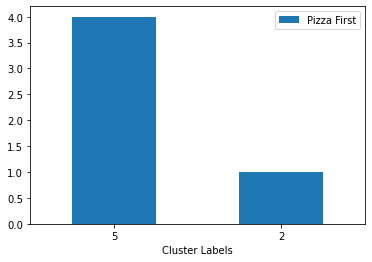

In [23]:
#Determine which cluster has the most Pizza Places and the "1st Most Common Venue"
pizza_first_df = brooklyn_merged.loc[brooklyn_merged['1st Most Common Venue'] == "Pizza Place"]
pizza_first_graph = pizza_first_df.groupby('Cluster Labels').size().sort_values(ascending=False).reset_index(name="Pizza First")
pizza_first_graph.plot.bar(x='Cluster Labels', y='Pizza First', rot=0)
pizza_first_graph

,Cluster Labels,Pizza 2nd
0,5,6
1,4,2
2,2,2


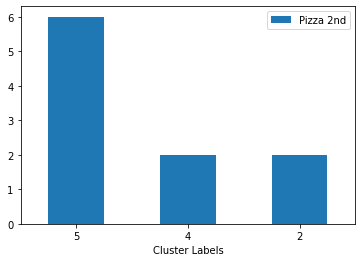

In [24]:
#Determine which cluster has the most Pizza Places and the "2nd" Most Common Venue"
pizza_2nd_df = brooklyn_merged.loc[brooklyn_merged['2nd Most Common Venue'] == "Pizza Place"]
pizza_2nd_graph = pizza_2nd_df.groupby('Cluster Labels').size().sort_values(ascending=False).reset_index(name="Pizza 2nd")
pizza_2nd_graph.plot.bar(x='Cluster Labels', y='Pizza 2nd', rot=0)
pizza_2nd_graph

,Cluster Labels,Pizza 3rd
0,5,5


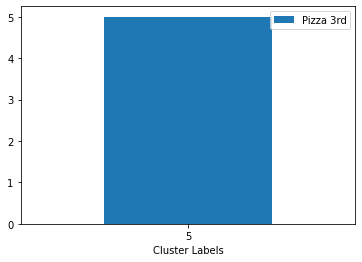

In [28]:
#Determine which cluster has the most Pizza Places and the "3rd" Most Common Venue"
pizza_3rd_df = brooklyn_merged.loc[brooklyn_merged['3rd Most Common Venue'] == "Pizza Place"]
pizza_3rd_graph = pizza_3rd_df.groupby('Cluster Labels').size().sort_values(ascending=False).reset_index(name="Pizza 3rd")
pizza_3rd_graph.plot.bar(x='Cluster Labels', y='Pizza 3rd', rot=0)
pizza_3rd_graph

In [30]:
#Explore Cluster 5
cluster_5 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 5, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
cluster_5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Spa,Pizza Place,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Middle Eastern Restaurant,Sandwich Place,Café
1,Bensonhurst,Chinese Restaurant,Grocery Store,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Bakery,Bar,Liquor Store,Pizza Place
3,Greenpoint,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Record Shop,French Restaurant,Furniture / Home Store,Yoga Studio,Grocery Store,Sushi Restaurant
4,Gravesend,Metro Station,Lounge,Pizza Place,Chinese Restaurant,Bakery,Italian Restaurant,Jewelry Store,Farmers Market,Furniture / Home Store,Bar
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Boat or Ferry,Yoga Studio,Grocery Store,Creperie,Hotel,Diner,Restaurant,Outlet Store


In [32]:
no_pizza = cluster_5.loc[(cluster_5['1st Most Common Venue'] != "Pizza Place") 
              & (cluster_5['2nd Most Common Venue'] != "Pizza Place") 
              & (cluster_5['3rd Most Common Venue'] != "Pizza Place")
              & (cluster_5['4th Most Common Venue'] != "Pizza Place")
              & (cluster_5['5th Most Common Venue'] != "Pizza Place")
              & (cluster_5['6th Most Common Venue'] != "Pizza Place") 
              & (cluster_5['7th Most Common Venue'] != "Pizza Place")
              & (cluster_5['8th Most Common Venue'] != "Pizza Place")
              & (cluster_5['9th Most Common Venue'] != "Pizza Place")
              & (cluster_5['10th Most Common Venue'] != "Pizza Place")
              & (cluster_5['1st Most Common Venue'] != "Italian Restaurant") 
              & (cluster_5['2nd Most Common Venue'] != "Italian Restaurant") 
              & (cluster_5['3rd Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['4th Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['5th Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['6th Most Common Venue'] != "Italian Restaurant") 
              & (cluster_5['7th Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['8th Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['9th Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['10th Most Common Venue'] != "Italian Restaurant")
              & (cluster_5['1st Most Common Venue'] != "Deli / Bodega") 
              & (cluster_5['2nd Most Common Venue'] != "Deli / Bodega") 
              & (cluster_5['3rd Most Common Venue'] != "Deli / Bodega")
              & (cluster_5['4th Most Common Venue'] != "Deli / Bodega")
              & (cluster_5['5th Most Common Venue'] != "Deli / Bodega")
              & (cluster_5['6th Most Common Venue'] != "Deli / Bodega") 
              & (cluster_5['7th Most Common Venue'] != "Deli / Bodega")
              & (cluster_5['8th Most Common Venue'] != "Deli / Bodega")
              & (cluster_5['9th Most Common Venue'] != "Deli / Bodega")
              & (cluster_5['10th Most Common Venue'] != "Deli / Bodega")]

no_pizza

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Boat or Ferry,Yoga Studio,Grocery Store,Creperie,Hotel,Diner,Restaurant,Outlet Store
13,Prospect Heights,Bar,Mexican Restaurant,Wine Shop,Bakery,Coffee Shop,Cocktail Bar,Diner,Ice Cream Shop,Southern / Soul Food Restaurant,Beer Bar
21,Red Hook,Seafood Restaurant,Art Gallery,Park,Bar,Bagel Shop,Wine Shop,Flower Shop,Ice Cream Shop,Café,American Restaurant
41,Boerum Hill,Coffee Shop,Dance Studio,Bar,Arts & Crafts Store,Sandwich Place,Furniture / Home Store,French Restaurant,Bakery,Spa,Chinese Restaurant
62,Vinegar Hill,Food Truck,Art Gallery,Coffee Shop,Café,Sandwich Place,Entertainment Service,Bakery,Scenic Lookout,Latin American Restaurant,Bike Rental / Bike Share


In [39]:
for_map = brooklyn_venues.loc[brooklyn_venues['Neighborhood'].isin(['Sheepshead Bay','Prospect Heights','Red Hook','Boerum Hill','Vinegar Hill'])] 

map_no_pizza = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(for_map['Neighborhood Latitude'], for_map['Neighborhood Longitude'], for_map['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_no_pizza)  

map_no_pizza
